In [2]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
import time
from scipy.stats  import norm
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, LSTM, Dropout, RepeatVector, Layer
from keras.regularizers import l2
from keras        import backend as K
from datetime     import datetime, timedelta
from keras.optimizers      import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 5

# number of inputs to be fed
look_back = 1
# number of outputs to be generated
look_forward = 12*2
# the scope of the LSTM Model
stations = 66
# weight decay
weight_decay=1e-7

# TB callback
tbCallBack = lambda name: keras.callbacks.TensorBoard(
    log_dir='ignored_assets/tf-log/' + str(name),
    histogram_freq=0,write_graph=True, write_images=True
)

Using TensorFlow backend.
/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Predicting with more preprocessing

In [3]:
class Transform:
    def __init__(self, feature_range=(-1,1), frequency='day', log=True):
        self.feature_range = feature_range
        self.log = log
        if frequency not in ['day', 'week']: 
            raise Exception('Frequency must be either day or week')
        self.frequency = frequency
        if frequency == 'day':
            self.freq = 288
        elif frequency == 'week':
            self.freq = 288 * 7
        
    def fit(self, dataset):
        '''
        Assumes dataset is a pandas dataframe
        '''
        # log transform
        if self.log:
            dlog = np.log(dataset + 1)
        self.seasonals = dlog.copy()
        self.columns = dlog.columns
        for c in dlog.columns:
            res = seasonal_decompose(dlog[c], freq=self.freq)
            self.seasonals[c] = res.seasonal
        self.scaler = MinMaxScaler(feature_range=self.feature_range)
        self.scaler.fit(dlog.values - self.seasonals.values)
        if self.frequency == 'day':
            self.seasonals['time'] = self.seasonals.index.time
            self.seasonals = self.seasonals.groupby('time').mean()
        elif self.frequency == 'week':
            self.seasonals['time'] = self.seasonals.index.hour * 60 + \
            self.seasonals.index.minute + self.seasonals.index.weekday * 24 * 60
            self.seasonals = self.seasonals.groupby('time').mean()
        return
        
    def transform(self, dataset):
        '''
        Assumes dataset is a pandas dataframe
        '''
        # box transform
        if self.log:
            dlog = np.log(dataset + 1)
        # get the corresponding seasonals
        if self.frequency == 'day':
            index = dlog.index.time
        elif self.frequency == 'week':
            index = dlog.index.hour * 60 + dlog.index.minute + dlog.index.weekday * 24 * 60
        # subtract seasonality
        dlog[self.columns] = dlog.values - self.seasonals.loc[index,dlog.columns].values
        # minmax scaler
        return self.scaler.transform(dlog.values)
    
    def inverse_transform(self, values, datetime_index):
        # inverse mimmax scaler
        vals = self.scaler.inverse_transform(values)
        # get the seasonality
        dlog = pd.DataFrame(vals, index=datetime_index, columns=self.columns)
        if self.frequency == 'day':
            index = dlog.index.time
        elif self.frequency == 'week':
            index = dlog.index.hour * 60 + dlog.index.minute + dlog.index.weekday * 24 * 60
        # add the seasonality
        dlog[self.columns] = dlog.values + self.seasonals.loc[index,dlog.columns].values
        # inverse box transform
        if self.log:
            return np.exp(dlog) - 1
        else:
            return dlog

In [5]:
# convert an array of values into a dataset matrix, adjusted to make a dateset that is 66 wide
def create_dataset(dataset, look_back=1, look_forward=2, not_in_Y=0):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        # Makes sure that the array isn't the last 2 or 3 or whatever bits. It has to be the full 24
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward,:])
    return np.array(dataX), np.array(dataY)

def batch_predict(model, datasets, transformer, prediction_indices):
    '''
        model is a trained keras model
        datasets is a list of valid dataframes
        transformer is the data transformer
        prediction_indices is a list of prediction indices
    '''
    batch_size = len(datasets)
    look_forward = len(prediction_indices[0])
    ncols = datasets[0].shape[-1]
    normalized_input = np.zeros((batch_size,) + datasets[0].shape)
    for i,d in enumerate(datasets):
        normalized_input[i,:,:] = transformer.transform(d)
    # predict
    output = model.predict(normalized_input, 50)
    dfs = []
    for i in range(output.shape[0]):
        dfs.append(transformer.inverse_transform(output[i,:,:], prediction_indices[i]))
    return dfs

def predict_with_uncertainty(model, dataset, ncols, n_iter=100):
    # This function activates drop-out when doing predictions
    f = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (look_forward,ncols,) )
    for i in range(n_iter):
        all_pred[i] = np.array( f([dataset.reshape( (1,) + dataset.shape), 1]) ).reshape(look_forward, ncols)
    avg_pred = all_pred.mean(axis=0)
    std = all_pred.std(axis=0)
    return all_pred, avg_pred, std

# given a model and data from the original dataset, it uses predict_with_uncertainty to predict with dropout
def run_predictions(model, dataset, transformer, prediction_tindex):

    # scale the dataset2
    data = transformer.transform(dataset)

    # feeds the model and data into a function that will activate the dropout
    all_pred, avg_pred, std = predict_with_uncertainty(model, data, dataset.shape[-1])
    # All the predictions
    #dummy_cols = np.zeros((all_pred.shape[1], 2))
    for i in range(all_pred.shape[0]):
        all_pred[i,:,:] = transformer.inverse_transform(all_pred[i,:,:], prediction_tindex)
    # The Standard Deviation At Each T Of Prediction
    #std = all_pred.std(axis=0)
    std_u = transformer.inverse_transform(avg_pred + std, prediction_tindex).values
    std_b = transformer.inverse_transform(avg_pred - std, prediction_tindex).values
    std_u2 = transformer.inverse_transform(avg_pred + 2*std, prediction_tindex).values
    std_b2 = transformer.inverse_transform(avg_pred - 2*std, prediction_tindex).values
    std = transformer.inverse_transform(std, prediction_tindex).values
    # The Average Prediction
    #avg_pred = all_pred.mean(axis=0)
    avg_pred = transformer.inverse_transform(avg_pred, prediction_tindex).values
    #print all_pred.mean(axis=0), avg_pred

    return all_pred, avg_pred, std, std_u, std_b, std_u2, std_b2


def predict (model, transformer, dataset, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    temp = rcParams['figure.figsize']
    rcParams['figure.figsize'] = 15, 3
    # creates matrices to hold the 
    ncols = dataset.shape[-1]
    avg_preds = np.zeros((288*total_days/delta, look_forward, stations))
    true_vals = np.zeros((288*total_days/delta, look_forward, stations))
    #cdf_vals  = np.zeros((288*total_days/delta, look_forward, stations))
    percent_over     = np.zeros(288*total_days/delta)
    percent_negative = np.zeros(288*total_days/delta)
    # Runs all the predictions
    for i in range (288*total_days/delta):
        # the point where the model will predict
        end = datetime(2016, 1, day) + timedelta(minutes=5) * delta * i
        start = end - (look_back-1) * timedelta(minutes=5)
        ptindex = [end + t*timedelta(minutes=5) for t in range(1,look_forward+1)]
        # Gets predictions
        print i
        all_pred, avg_pred, std, std_u, std_b, std_u2, std_b2 = run_predictions(model, dataset.loc[start:end,:], transformer, ptindex)
        # Gets the True Values
        true_val = dataset.loc[ptindex,:]
        percent_negative[i] = 100.0 * (all_pred < 0).sum() / all_pred.size
        # converts the original values to cdf values according to the cumullative distibution functions at t+1, t+2, ..., t+24 (0.0-1.0)
        # Adds the values to the overall matrix of cdf
        #cdf_vals[i,:,:] = norm.cdf(true_val, loc=avg_pred, scale=std)
        avg_preds[i], true_vals[i] = avg_pred, true_val
        if(show_graph):
            for j in np.arange(stations):
                plt.figure(j)
                # plots the uncertainty to the degree of half a standard deviation
                #plt.plot(ptindex, all_pred[:,:,j].T, color='red', alpha=0.1)
                plt.fill_between(ptindex, 
                                 std_u[:,j], 
                                 std_b[:,j], 
                                 facecolor='red', alpha=0.25)
                # plots the uncertainty to the degree of a full standard deviation
                plt.fill_between(ptindex, 
                                 std_u2[:,j], 
                                 std_b2[:,j], 
                                 facecolor='red', alpha=0.25)
                # plots the average predictions
                plt.plot(ptindex, avg_pred[:,j], color='red', alpha=1)
    print "Percent Negative: {}".format(np.mean(percent_negative))
    if show_graph:
        start = datetime(2016, 1, day)
        end = start + timedelta(days=total_days) + timedelta(minutes=5)*look_forward
        for i in range (stations):
            c = dataset.columns[i]
            plt.figure(i)
            plt.ylim(0,dataset.loc[start:end,c].max())
            plt.plot( dataset.loc[start:end,c].index, dataset.loc[start:end,c])
            plt.axhline(0)
        plt.show()
    if show_gradual_error:
        indiv_err = true_vals - avg_preds
        for i in range(look_forward):
            plt.scatter(np.ones(len(indiv_err[:,i]))*i,indiv_err[:,i], color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    rcParams['figure.figsize'] = temp
    return #cdf_vals


In [6]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
station_names = dataframe.columns
# add whether it is weekday and time step of the day
#dataframe['minute'] = (dataframe.index.hour*60 + dataframe.index.minute) % 288
#dataframe['weekday'] = (dataframe.index.weekday < 5).astype(np.int64)

In [7]:
# creates a model but does not compile the model
def create_model(rate=0.25, ncols = 66):

    model = Sequential()
    #model.add(Dropout(
    #    rate,
    #    input_shape=(look_back, stations+2),
    #))
    model.add(LSTM(
        ncols/2,
        input_shape=(look_back, ncols),
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_regularizer = l2(weight_decay),
        bias_regularizer = l2(weight_decay),
        recurrent_regularizer = l2(weight_decay),
    ))  # Encoder 1
    model.add(Dropout(
        rate,
    ))
    model.add(LSTM(
        ncols / 4,
        return_sequences=False,
        recurrent_dropout=0.3,
        kernel_regularizer = l2(weight_decay),
        bias_regularizer = l2(weight_decay),
        recurrent_regularizer = l2(weight_decay),
    ))  # Encoder 2
    model.add(Dropout(
        rate,
    ))
    model.add(RepeatVector(look_forward))
    model.add(Dropout(
        rate,
    ))
    model.add(LSTM(
        ncols/4,
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_regularizer = l2(weight_decay),
        bias_regularizer = l2(weight_decay),
        recurrent_regularizer = l2(weight_decay),
    ))  # Decoder
    model.add(Dropout(
        rate,
    ))
    model.add(LSTM(
        ncols/2,
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_regularizer = l2(weight_decay),
        bias_regularizer = l2(weight_decay),
        recurrent_regularizer = l2(weight_decay),
    ))  # Decoder
    model.add(Dropout(
        rate,
    ))
    model.add(LSTM(
        ncols,
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_regularizer = l2(weight_decay),
        bias_regularizer = l2(weight_decay),
        recurrent_regularizer = l2(weight_decay),
    ))  # Decoder
    model.add(Dropout(
        rate,
    )) 
    model.add(TimeDistributed(Dense(
        ncols,
        #activation="relu",
        kernel_regularizer = l2(weight_decay),
        bias_regularizer = l2(weight_decay),
    )))
    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print "Compilation Time : ", time.time() - start
    model.summary()
    print "Inputs: {}".format(model.input_shape)
    print "Outputs: {}".format(model.output_shape)
    return model

Great, now train it on the whole thing.

In [8]:
train_size = 288 * 15

# create transform (transformer should only look at training data)
transformer = Transform(frequency='day')
transformer.fit(dataframe.iloc[:train_size,:])
dataset = transformer.transform(dataframe)

# split into train and test sets
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

In [11]:
# Seeds before training
np.random.seed(369)
# create and fit the LSTM network
model = create_model()
# trains the model
model.fit(trainX, trainY, epochs=30, batch_size=50, 
          verbose=3, validation_data=(testX, testY), callbacks=[tbCallBack('dayseas_to_'+str(look_back)+'b_'+str(look_forward)+'f')])
# evaluates the model and prints the result
print 'Train Error', model.evaluate(trainX, trainY, verbose=2)
print 'Test Error', model.evaluate(testX, testY, verbose=2)

Compilation Time :  0.0208578109741
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 33)             13200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 33)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 16)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 

0


/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1
2
3
4
5
6
7
8
9
10
11
Percent Negative: 2.41608796296


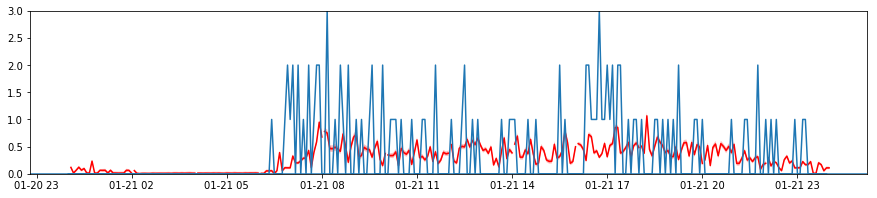

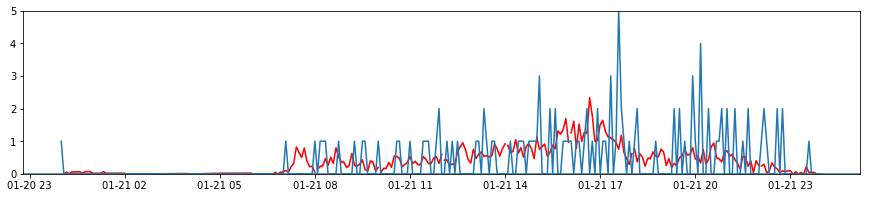

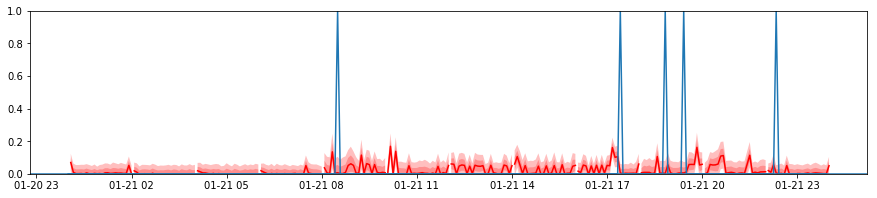

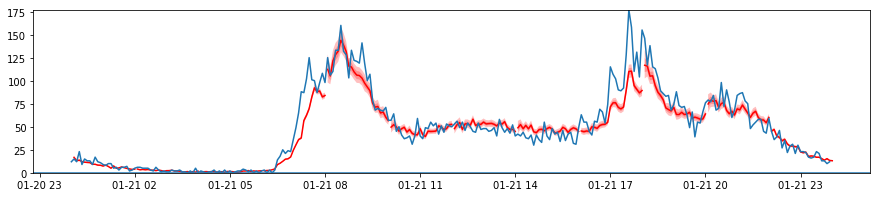

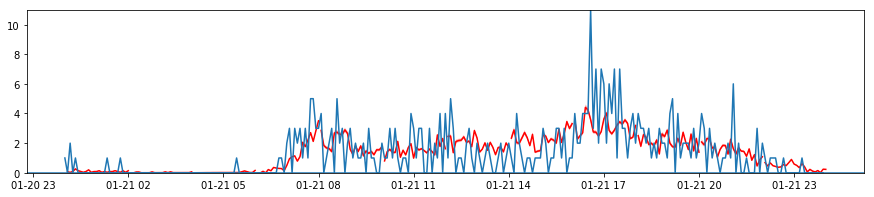

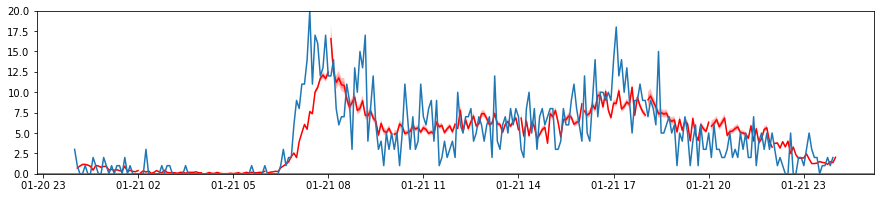

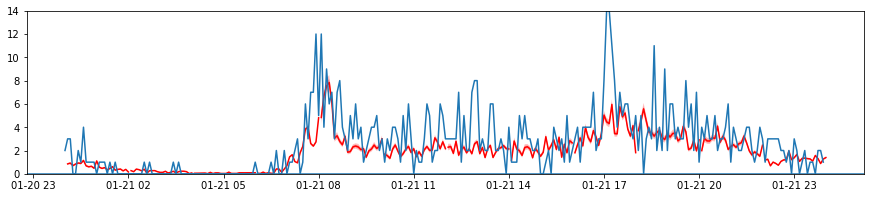

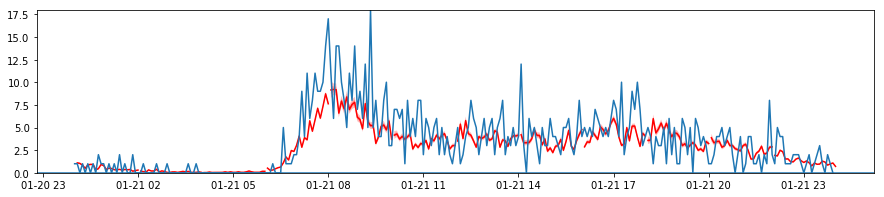

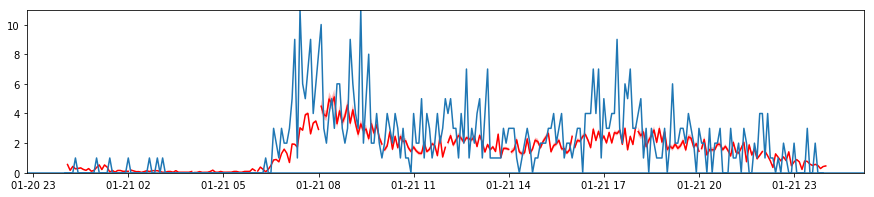

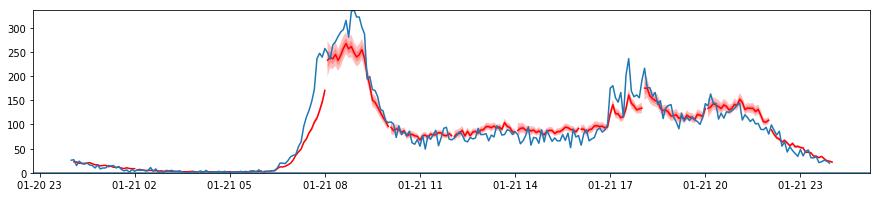

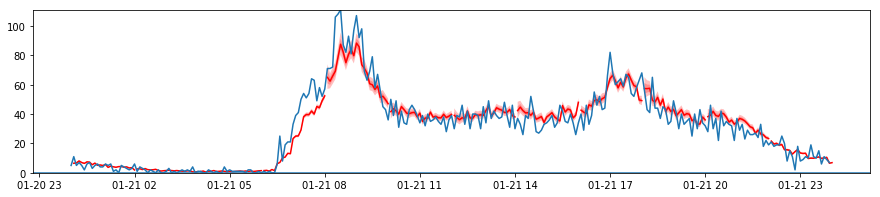

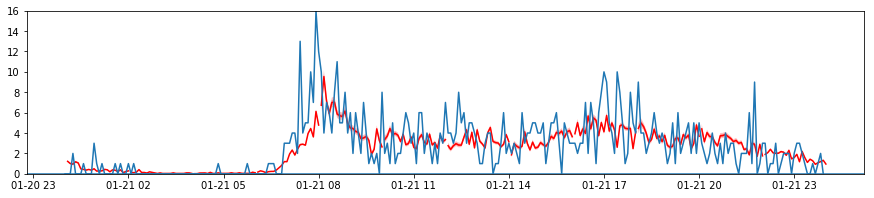

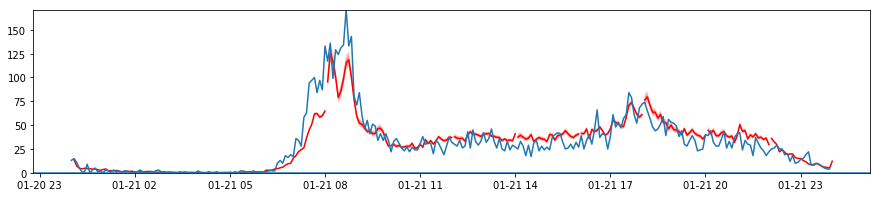

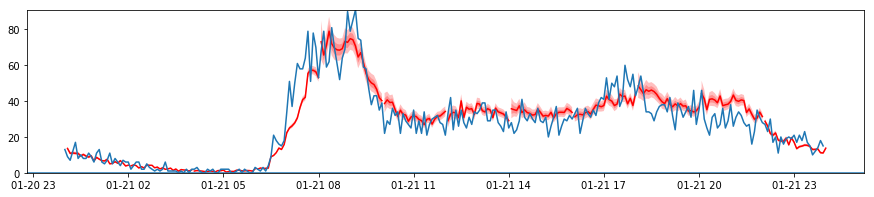

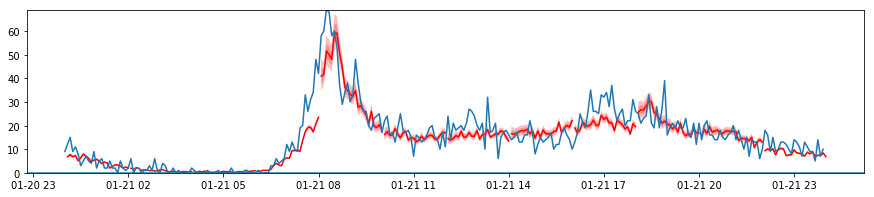

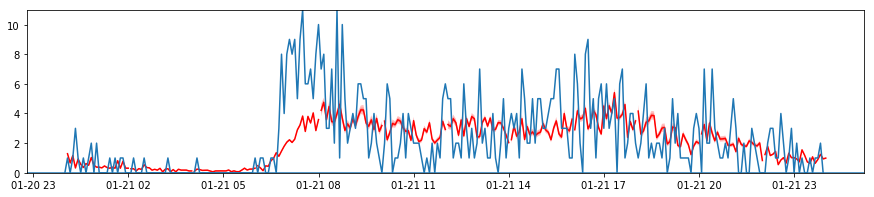

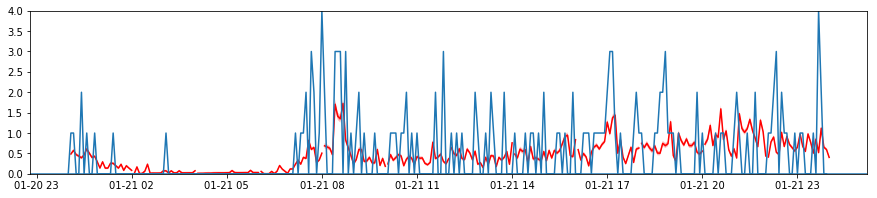

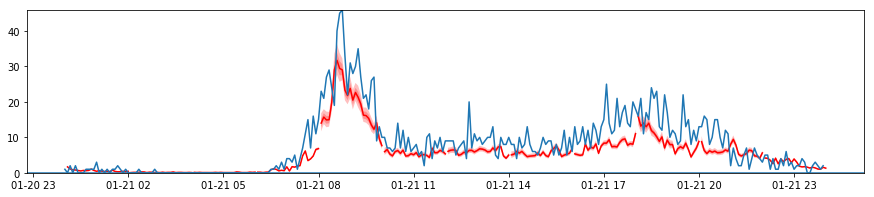

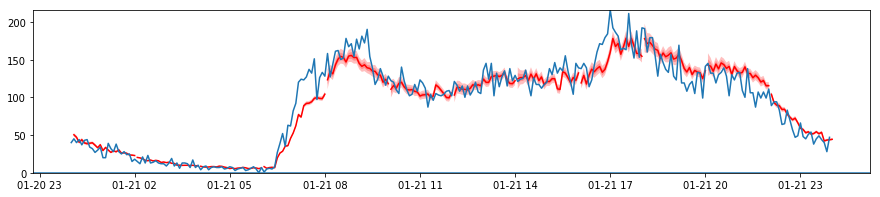

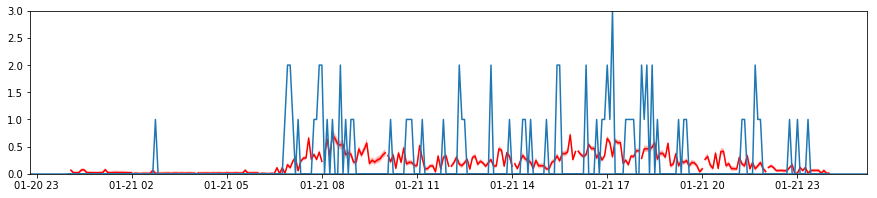

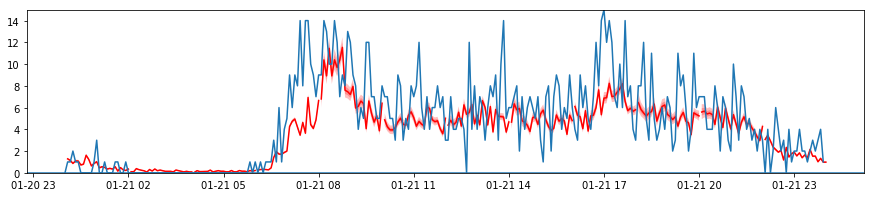

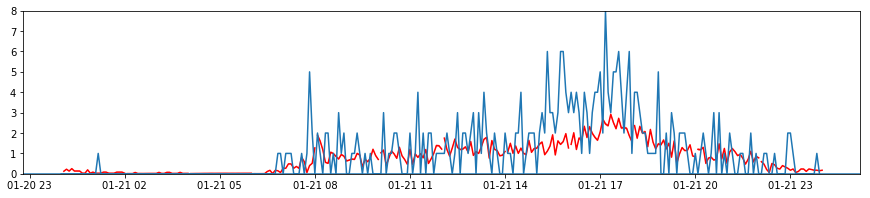

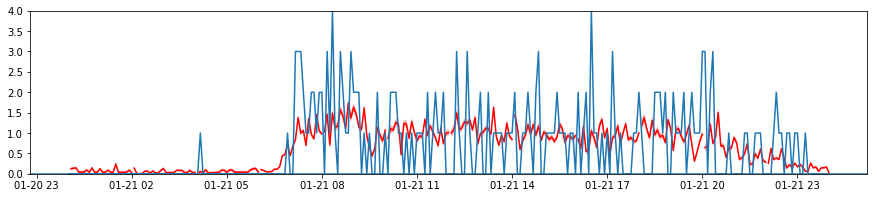

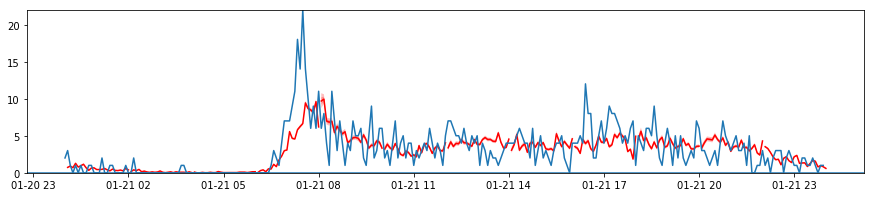

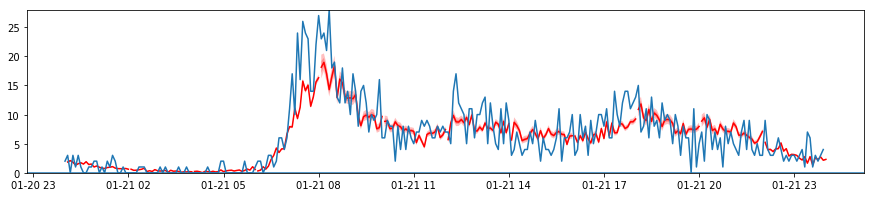

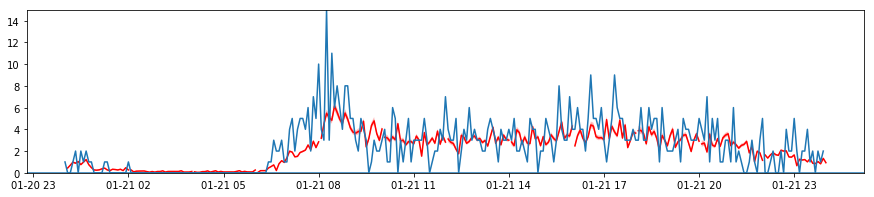

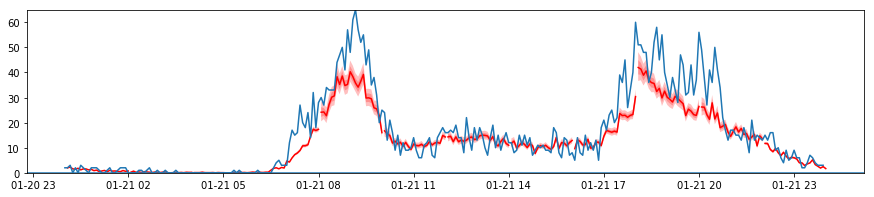

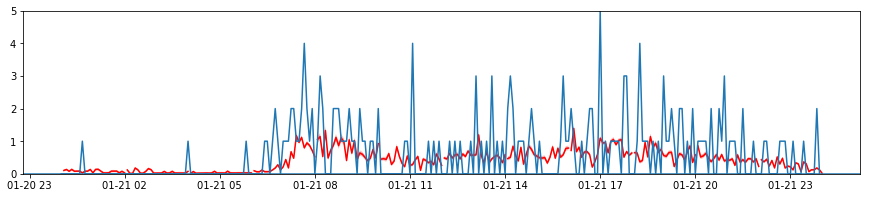

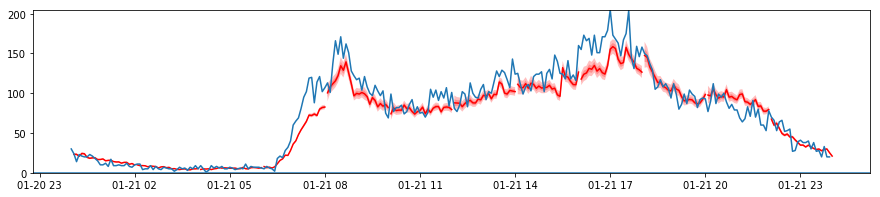

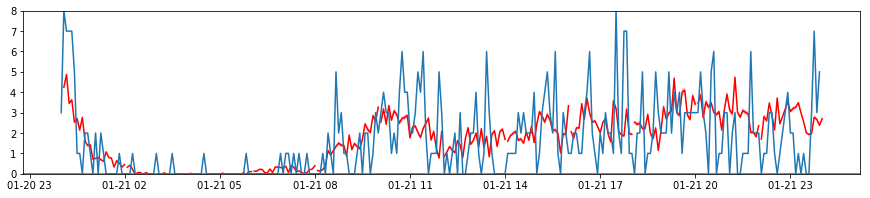

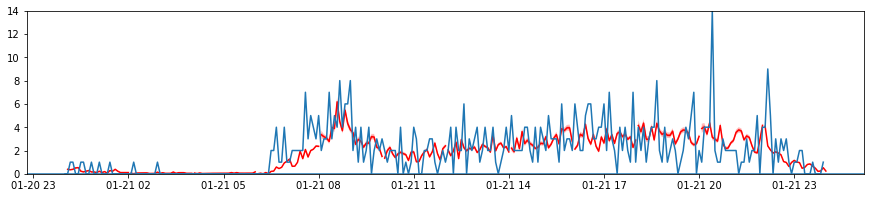

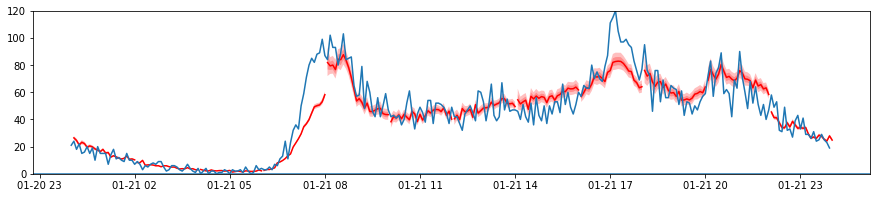

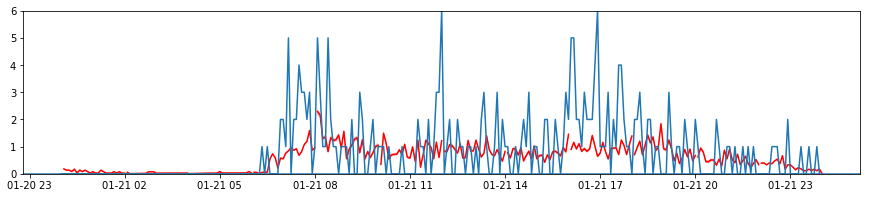

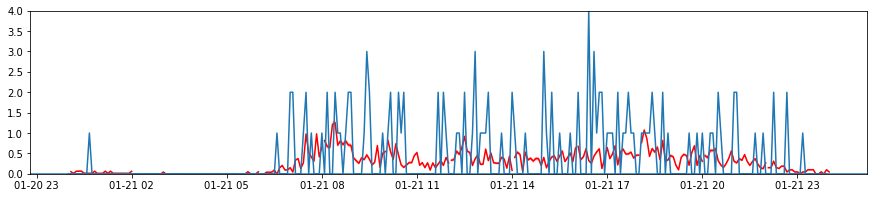

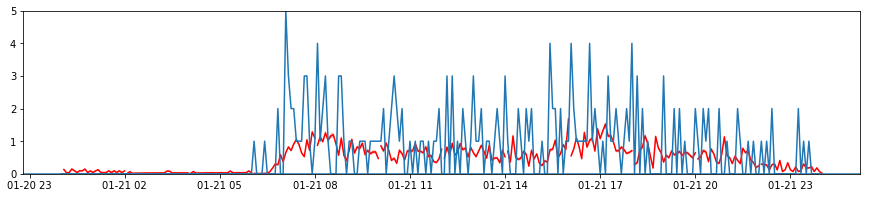

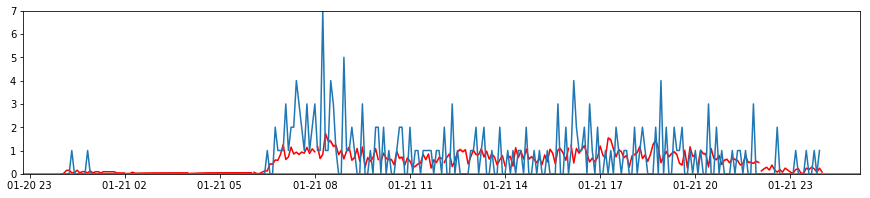

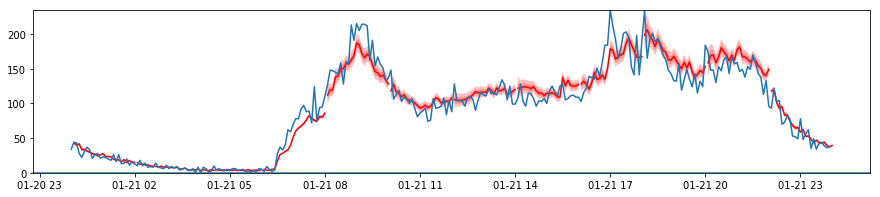

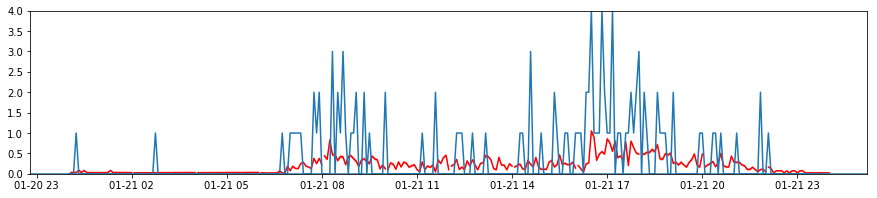

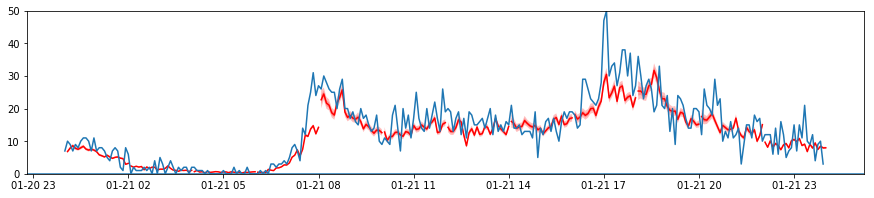

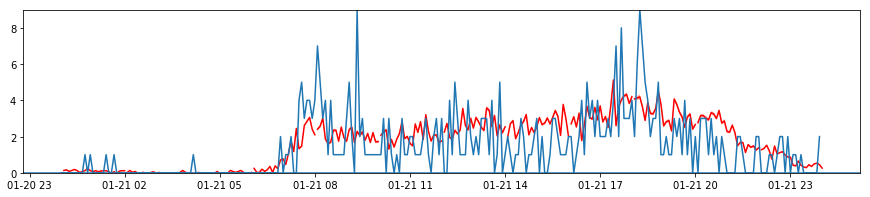

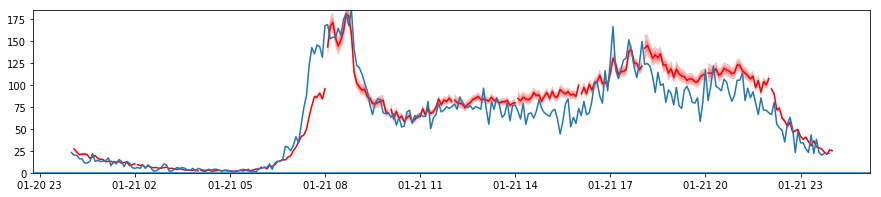

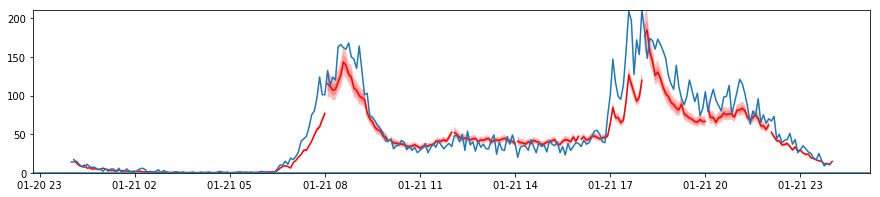

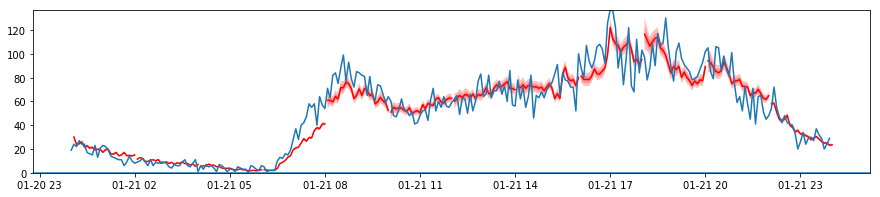

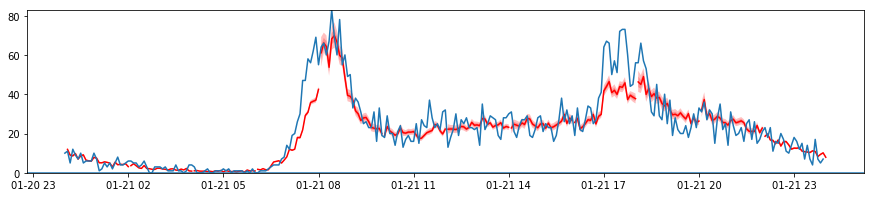

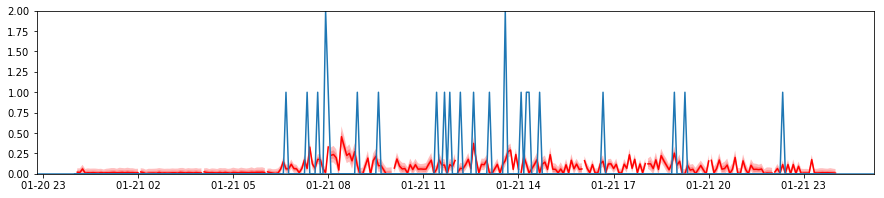

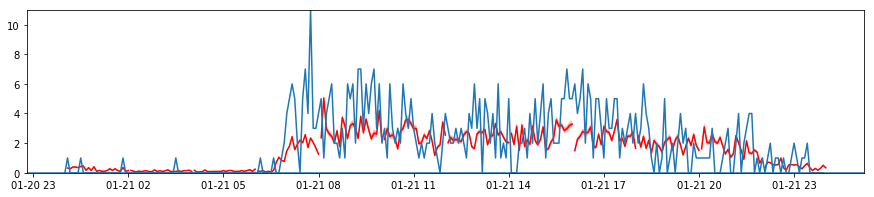

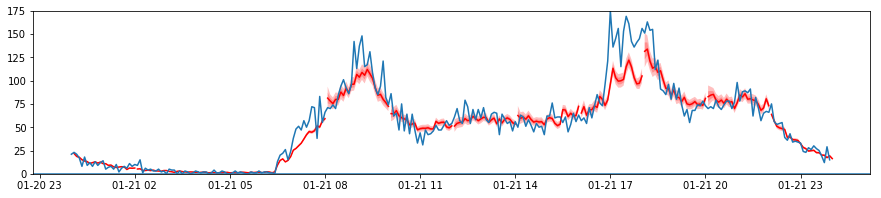

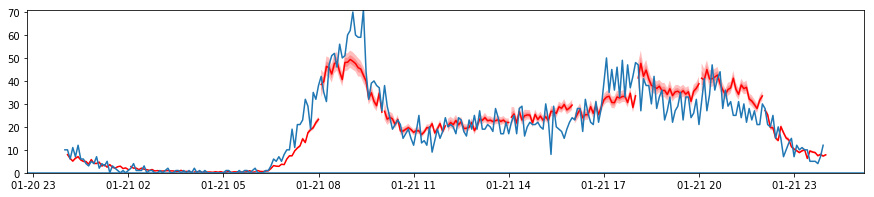

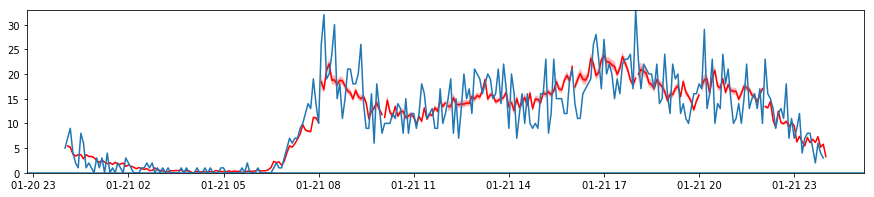

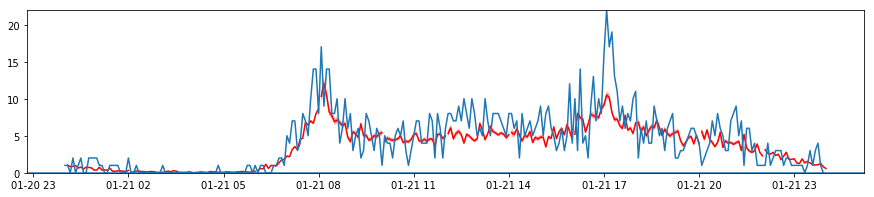

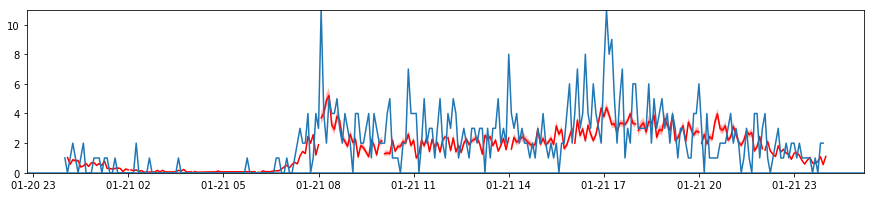

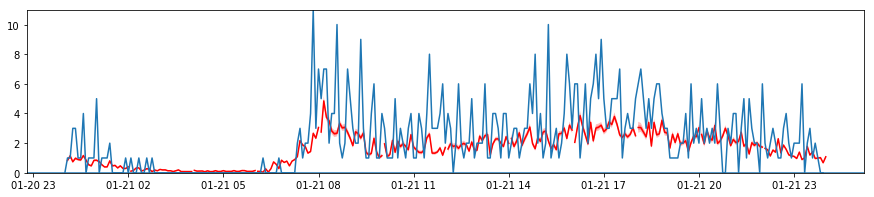

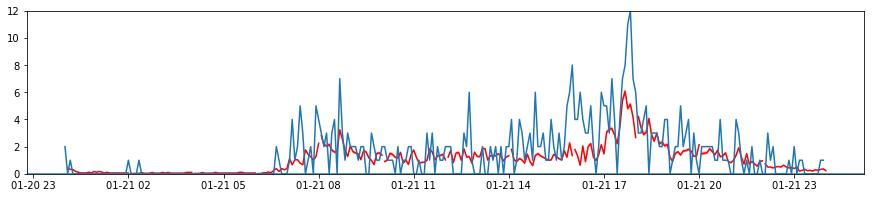

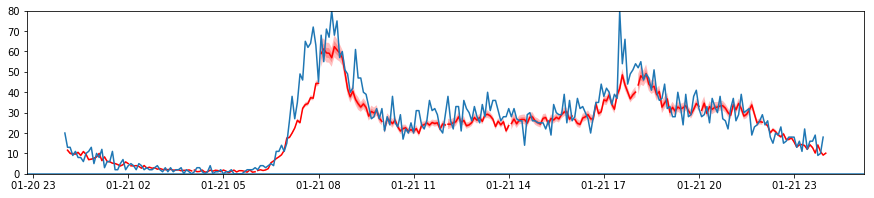

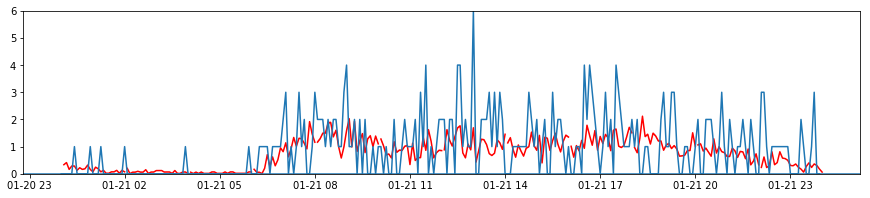

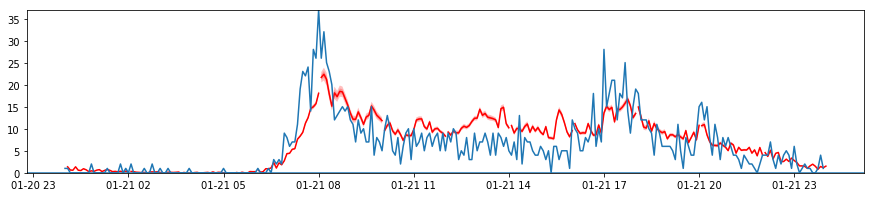

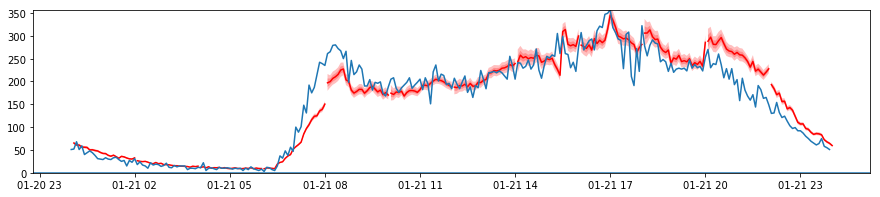

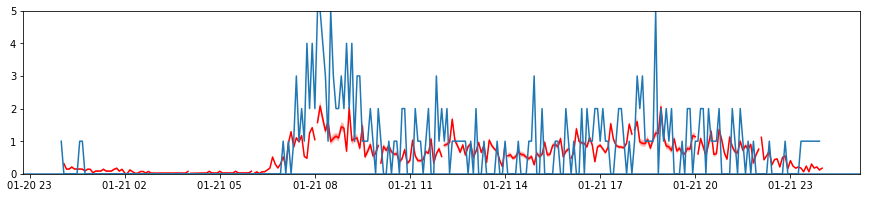

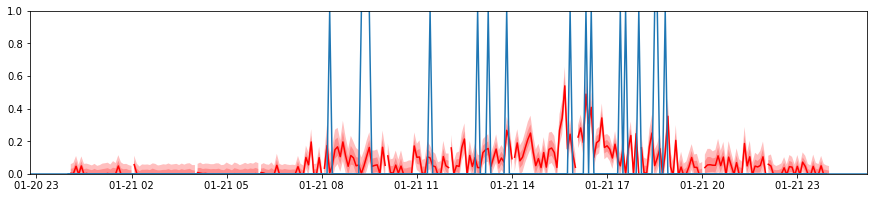

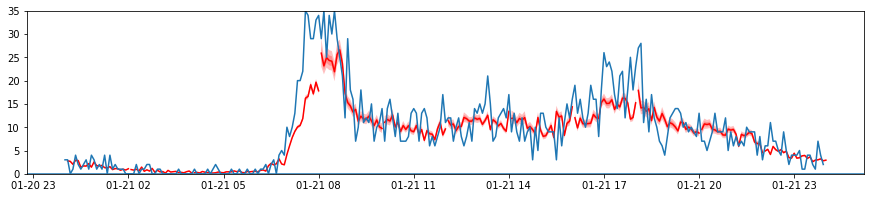

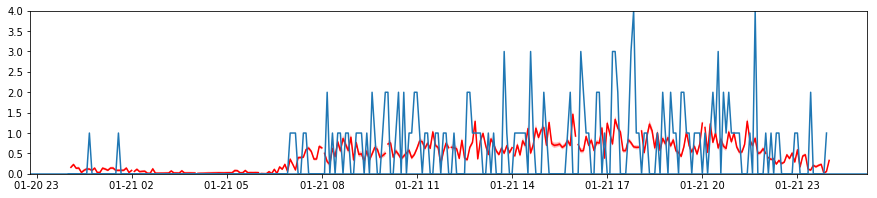

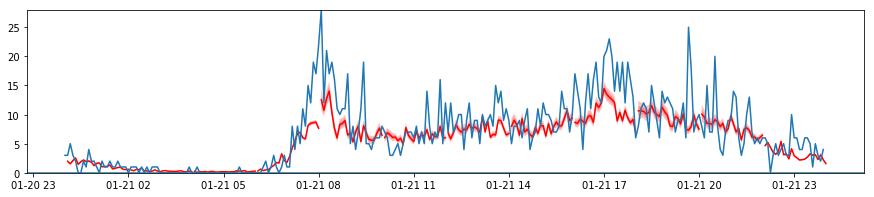

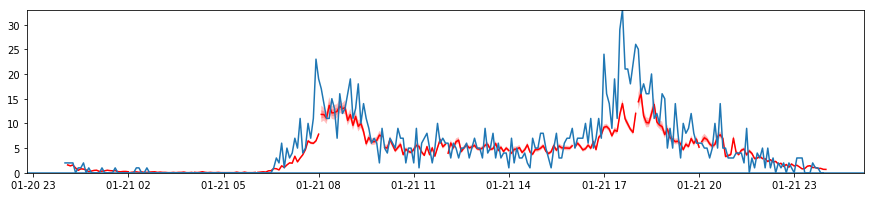

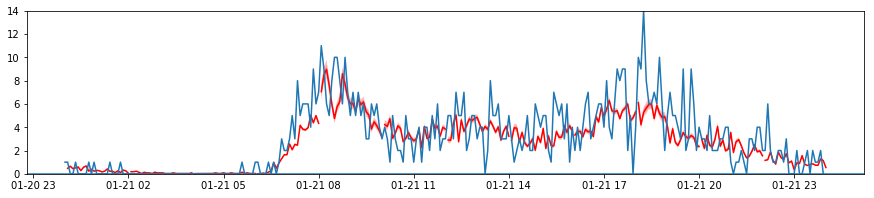

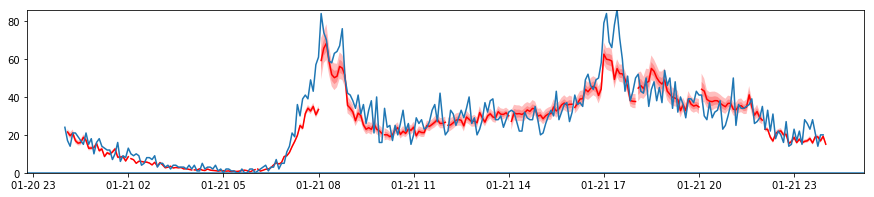

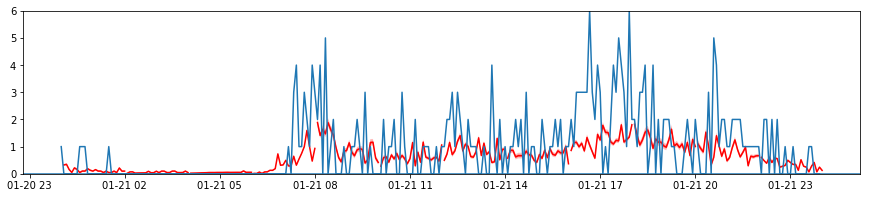

In [12]:
predict(model, transformer, dataframe, total_days=1,day=21,delta=24)

## make predictions for 01/21/2016

In [13]:
start = datetime(2016, 1, 21) - timedelta(minutes=5)
npred = 289
stepsize = timedelta(minutes=5)
tindex = [start + i*stepsize for i in range(npred)]

In [14]:
dfs = []
for present in tindex:
    # the point where the model will predict
    past = present - (look_back-1) * timedelta(minutes=5)
    ptindex = [present + t*timedelta(minutes=5) for t in range(1,look_forward+1)]
    # Gets predictions
    all_pred, avg_pred, std, std_u, std_b, std_u2, std_b2 = run_predictions(model, dataframe.loc[past:present,:], transformer, ptindex)
    df = pd.DataFrame(avg_pred, columns=dataframe.columns)
    df['predicted_at'] = present
    df['timestamp'] = ptindex
    dfs.append(df)

In [15]:
predictions21 = pd.concat(dfs)

In [16]:
seas = transformer.inverse_transform(np.zeros_like(dataframe.loc[tindex,:].values), tindex)

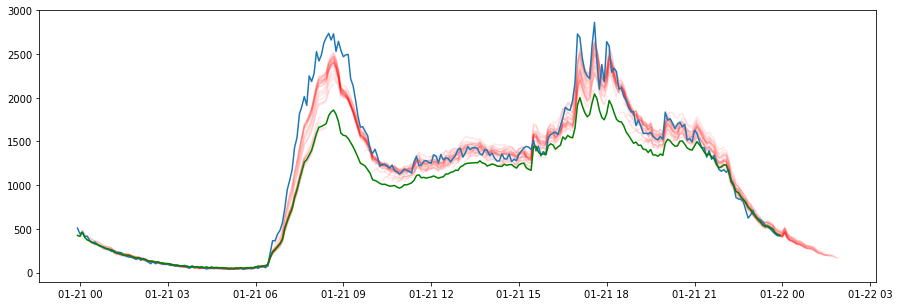

In [17]:
for t in tindex:
    df = predictions21[predictions21['predicted_at'] == t]
    plt.plot(df['timestamp'], df[list(dataframe.columns)].sum(axis=1), alpha = 0.1, color = 'red')

plt.plot(dataframe.loc[tindex,:].sum(axis=1))
plt.plot(seas.sum(axis=1), color='green')

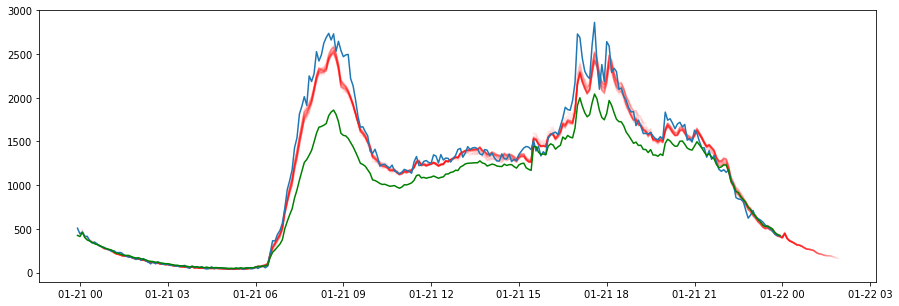

In [72]:
for t in tindex:
    df = predictions21[predictions21['predicted_at'] == t]
    plt.plot(df['timestamp'], df[list(dataframe.columns)].sum(axis=1), alpha = 0.1, color = 'red')

plt.plot(dataframe.loc[tindex,:].sum(axis=1))
plt.plot(seas.sum(axis=1), color='green')

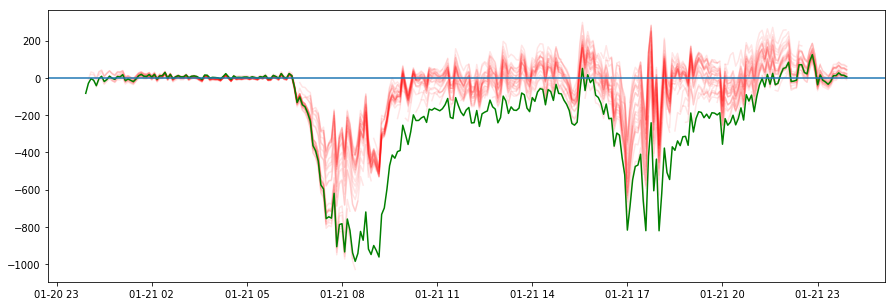

In [18]:
for t in tindex:
    df = predictions21[predictions21['predicted_at'] == t].set_index('timestamp')
    try:
        diff = df[list(dataframe.columns)].sum(axis=1) - dataframe.loc[df.index,:].sum(axis=1)
    except:
        continue
    plt.plot(df.index, diff, alpha = 0.1, color = 'red')

#plt.plot(dataframe.loc[tindex,:].sum(axis=1))
diff = seas.sum(axis=1) - dataframe.loc[tindex,:].sum(axis=1)
plt.plot(diff, color='green')
plt.axhline(0)

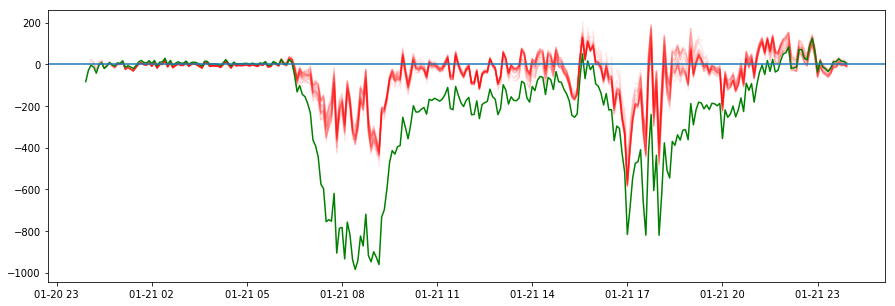

In [73]:
for t in tindex:
    df = predictions21[predictions21['predicted_at'] == t].set_index('timestamp')
    try:
        diff = df[list(dataframe.columns)].sum(axis=1) - dataframe.loc[df.index,:].sum(axis=1)
    except:
        continue
    plt.plot(df.index, diff, alpha = 0.1, color = 'red')

#plt.plot(dataframe.loc[tindex,:].sum(axis=1))
diff = seas.sum(axis=1) - dataframe.loc[tindex,:].sum(axis=1)
plt.plot(diff, color='green')
plt.axhline(0)

In [ ]:
predictions21.to_csv('ignored_assets/new_lstm_to_pred.csv', index=False)

## make predictions for 01/21/2016 assuming weekend demand

In [19]:
fake_df = dataframe.copy()
mask1 = fake_df.index.date == datetime(2016, 1, 21).date()
mask2 = fake_df.index.date == datetime(2016, 1, 16).date()

fake_df.loc[mask1,:] = fake_df[fake_df.columns][mask2].values

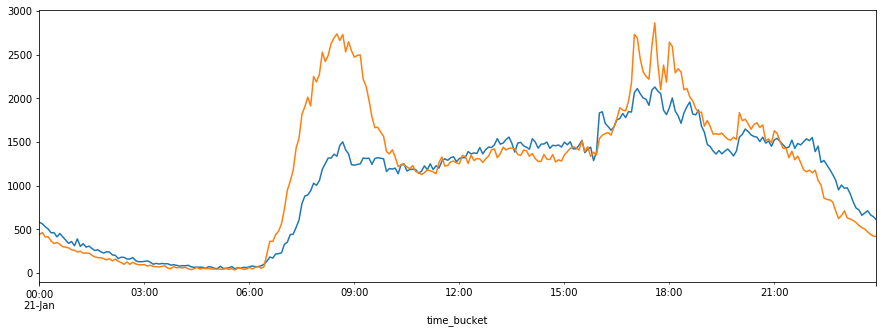

In [20]:
fake_df.loc[mask1,:].sum(axis=1).plot()
dataframe.loc[mask1,:].sum(axis=1).plot()

In [21]:
dfs = []
for present in tindex:
    # the point where the model will predict
    past = present - (look_back-1) * timedelta(minutes=5)
    ptindex = [present + t*timedelta(minutes=5) for t in range(1,look_forward+1)]
    # Gets predictions
    all_pred, avg_pred, std, std_u, std_b, std_u2, std_b2 = run_predictions(model, fake_df.loc[past:present,:], transformer, ptindex)
    df = pd.DataFrame(avg_pred, columns=fake_df.columns)
    df['predicted_at'] = present
    df['timestamp'] = ptindex
    dfs.append(df)

In [22]:
fpredictions21 = pd.concat(dfs)
seas = transformer.inverse_transform(np.zeros_like(dataframe.loc[tindex,:].values), tindex)

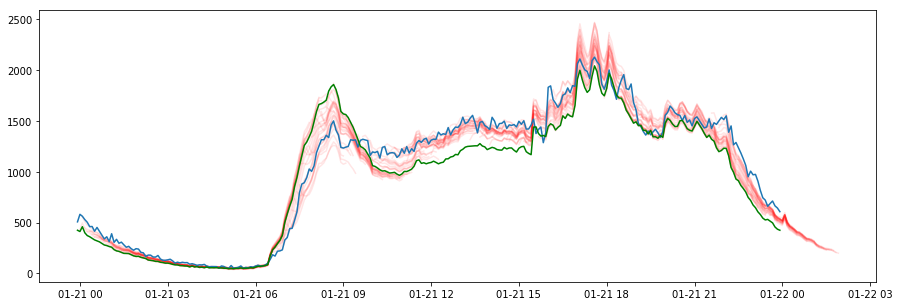

In [23]:
for t in tindex:
    df = fpredictions21[fpredictions21['predicted_at'] == t]
    plt.plot(df['timestamp'], df[list(fake_df.columns)].sum(axis=1), alpha = 0.1, color = 'red')

plt.plot(fake_df.loc[tindex,:].sum(axis=1))
plt.plot(seas.sum(axis=1), color='green')

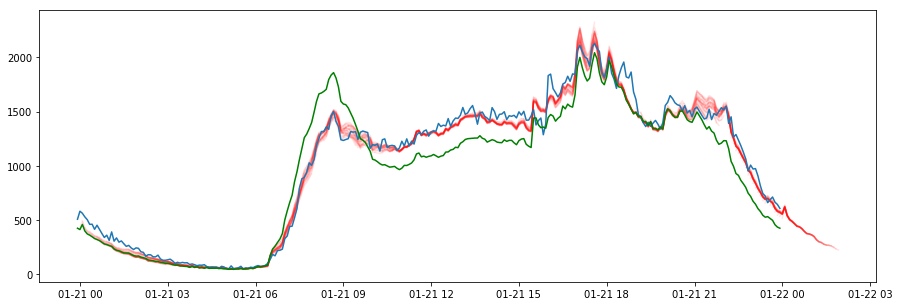

In [80]:
for t in tindex:
    df = fpredictions21[fpredictions21['predicted_at'] == t]
    plt.plot(df['timestamp'], df[list(fake_df.columns)].sum(axis=1), alpha = 0.1, color = 'red')

plt.plot(fake_df.loc[tindex,:].sum(axis=1))
plt.plot(seas.sum(axis=1), color='green')

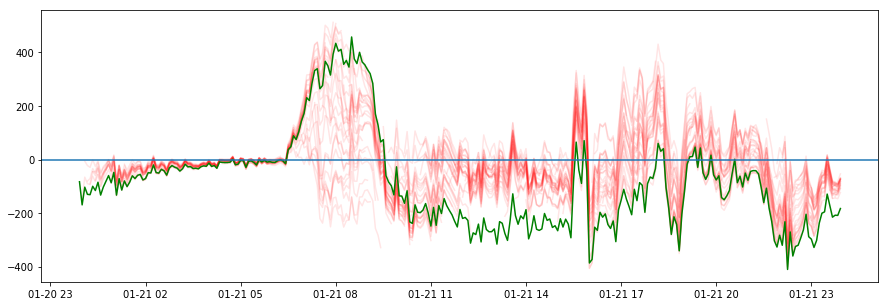

In [24]:
for t in tindex:
    df = fpredictions21[fpredictions21['predicted_at'] == t].set_index('timestamp')
    try:
        diff = df[list(fake_df.columns)].sum(axis=1) - fake_df.loc[df.index,:].sum(axis=1)
    except:
        continue
    plt.plot(df.index, diff, alpha = 0.1, color = 'red')

#plt.plot(dataframe.loc[tindex,:].sum(axis=1))
diff = seas.sum(axis=1) - fake_df.loc[tindex,:].sum(axis=1)
plt.plot(diff, color='green')
plt.axhline(0)

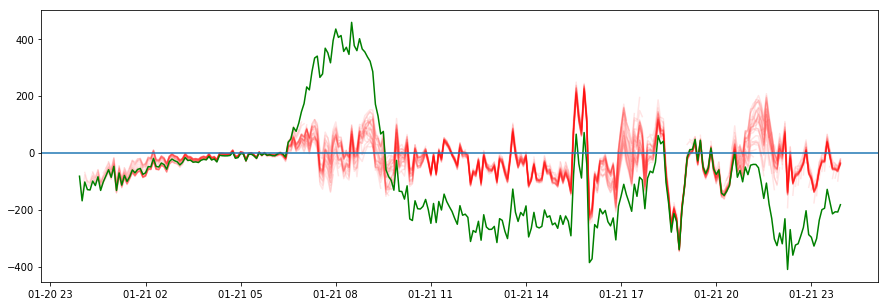

In [82]:
for t in tindex:
    df = fpredictions21[fpredictions21['predicted_at'] == t].set_index('timestamp')
    try:
        diff = df[list(fake_df.columns)].sum(axis=1) - fake_df.loc[df.index,:].sum(axis=1)
    except:
        continue
    plt.plot(df.index, diff, alpha = 0.1, color = 'red')

#plt.plot(dataframe.loc[tindex,:].sum(axis=1))
diff = seas.sum(axis=1) - fake_df.loc[tindex,:].sum(axis=1)
plt.plot(diff, color='green')
plt.axhline(0)

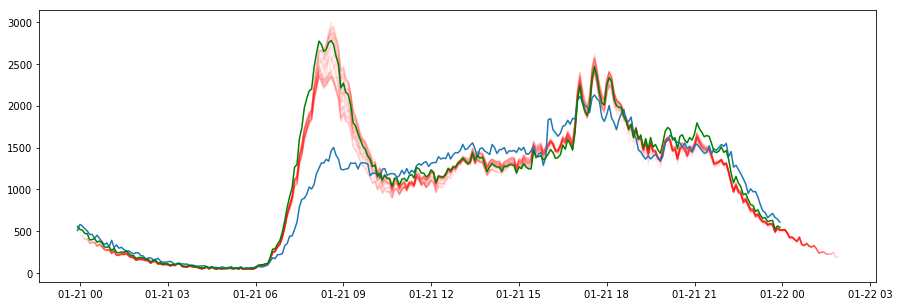

In [59]:
for t in tindex:
    df = fpredictions21[fpredictions21['predicted_at'] == t]
    plt.plot(df['timestamp'], df[list(fake_df.columns)].sum(axis=1), alpha = 0.1, color = 'red')

plt.plot(fake_df.loc[tindex,:].sum(axis=1))
plt.plot(seas.sum(axis=1), color='green')

## TOD

For this we need to first convert our ncolumns from $N$ to $N^2$.  The steps for that are
- Function to neatly transform dataframe with columns 

In [117]:
# 1 distribution by source & time

# load data
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6])

# create map of core stations
core_stations = orderdf['start_district_hash'].unique()
core_stations.sort()

#Index stuff
orderdf=orderdf[(~pd.isnull(orderdf['driver_id'])) & orderdf['dest_district_hash'].isin(core_stations)]

orderdf['time_bucket'] = orderdf['timestamp'].dt.round('5min')
orderdf = orderdf[orderdf['time_bucket'] < datetime(2016,1,22)]

In [118]:
# groupby 
tod_df = pd.pivot_table(orderdf, 
                  values=['order_id'], 
                  index='time_bucket', 
                  columns=['start_district_hash','dest_district_hash'],
                  aggfunc=len,
                  fill_value=0,
                  dropna=False,
                 )

In [119]:
tod_df.shape

(6048, 4356)

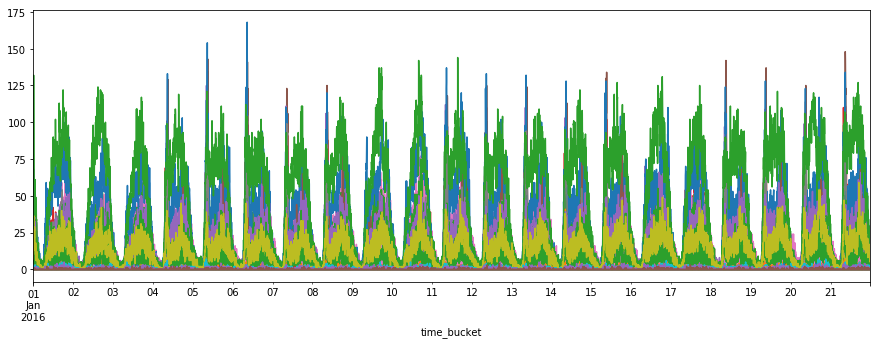

In [120]:
tod_df.plot(legend=False)

## Train TOD

In [134]:
train_size = 288 * 15

# create transform (transformer should only look at training data)
transformer = Transform(frequency='day')
transformer.fit(tod_df.iloc[:train_size,:])
dataset = transformer.transform(tod_df)

# split into train and test sets
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

In [139]:
K.clear_session()

In [140]:
trainX.shape

(4213, 60, 4356)

In [385]:
K.clear_session()

In [386]:
# Seeds before training
np.random.seed(369)
# create and fit the LSTM network
model = create_model(ncols=trainX.shape[-1])
# trains the model
model.fit(trainX, trainY, epochs=30, batch_size=50, 
          verbose=3, validation_data=(testX, testY), callbacks=[tbCallBack('dayseas_tod_3b_2f')])
# evaluates the model and prints the result
print 'Train Error', model.evaluate(trainX, trainY, verbose=2)
print 'Test Error', model.evaluate(testX, testY, verbose=2)

KeyboardInterrupt: 

In [359]:
print 'Train Error', model.evaluate(trainX, trainY, verbose=2)
print 'Test Error', model.evaluate(testX, testY, verbose=2)

 Train Error 0.0181646216342
Test Error 0.0170816194493


In [362]:
Y = model.predict(trainX[-1:,:,:],50)

In [245]:
dfs = []
pats = []
tstamps = []
for i,present in enumerate(tindex):
    # the point where the model will predict
    past = present - (look_back-1) * timedelta(minutes=5)
    ptindex = [present + t*timedelta(minutes=5) for t in range(1,look_forward+1)]
    dfs.append(tod_df.loc[past:present,:])
    pats.append([present]*len(ptindex))
    tstamps.append(ptindex)

In [388]:
# Gets predictions
t1 = time.time()
df_out = batch_predict(model, dfs, transformer, pats)
df_out = pd.concat(df_out)
t2 = time.time()
print 'pred time:',t2-t1, '|'

KeyboardInterrupt: 

In [267]:
df_out['predicted_at'] = np.concatenate(pats)
df_out['timestamp'] = np.concatenate(tstamps)
seas = transformer.inverse_transform(np.zeros_like(tod_df.loc[tindex,:].values), tindex)

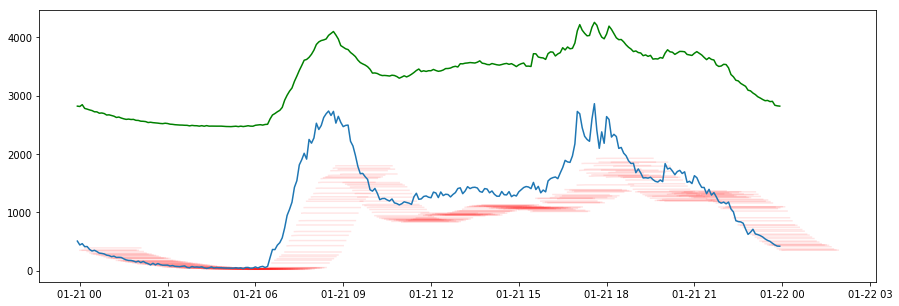

In [304]:
for t in tindex:
    df = df_out[df_out['predicted_at'] == t]
    plt.plot(df['timestamp'], df[tod_df.columns].round().sum(axis=1), alpha = 0.1, color = 'red')

plt.plot(tod_df.loc[tindex,:].sum(axis=1))
plt.plot(seas.round().sum(axis=1), color='green')

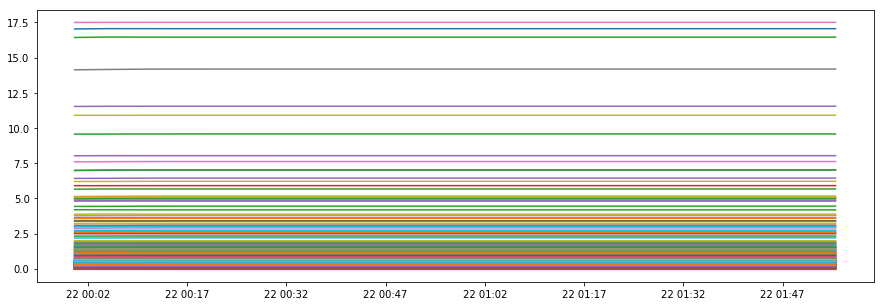

In [356]:
plt.plot(df['timestamp'],df[tod_df.columns].values);#.plot(legend=False);

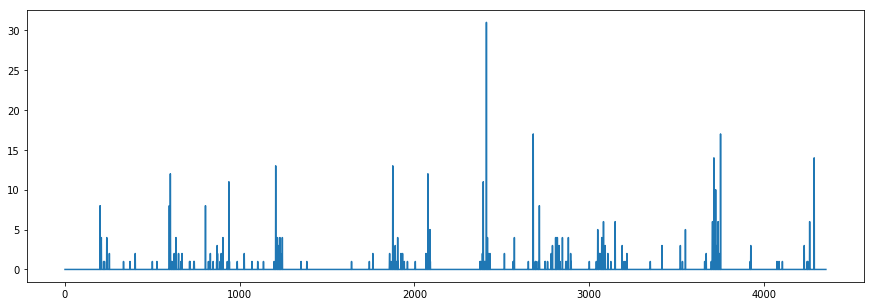

In [341]:
plt.plot(tod_df.loc[tindex,:].values[0,:])

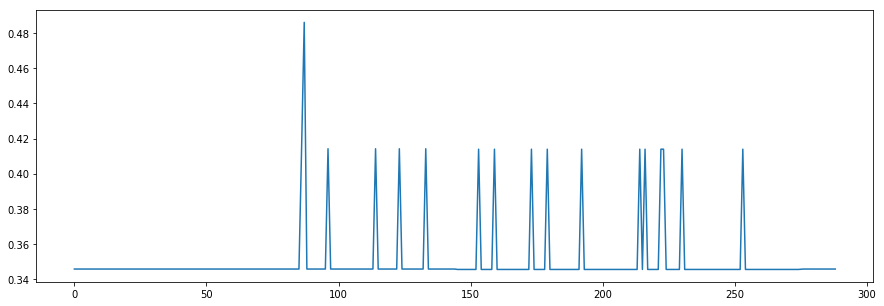

In [382]:
plt.plot(seas.values[:,8])

In [308]:
seas.values[0,:].round().sum()

2821.0

In [300]:
seas.values[0,:].shape[0]

4356

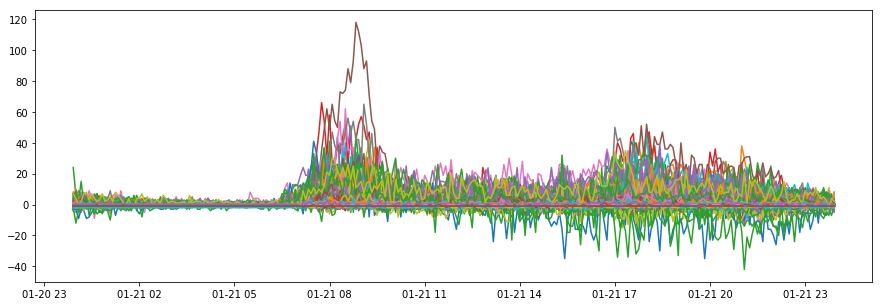

In [305]:
plt.plot(tod_df.loc[tindex,:] -  .round());